In [12]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import tensorflow as tf
from keras import models
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Paths
CURRENT_DIR = Path(os.getcwd())
DATASET_PATH = CURRENT_DIR / "data" / "dataset" / "dataset_scale_25k.npz"
FCNN_PATH = CURRENT_DIR / "baseline_model" / "fcnn_model.keras"
CNN_PATH = CURRENT_DIR / "CNN" / "finger_press_cnn_v4.keras"
RES_CNN_PATH = CURRENT_DIR / "residual_CNN" / "residual_cnn.keras"

FINGER_NAMES = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
THRESHOLD = 0.5 # Default threshold, might need adjustment per model if they use logits

print("Libraries loaded and paths defined.")

Libraries loaded and paths defined.


In [13]:
# Helper Functions

def load_data(path):
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    data = np.load(path)
    return data

def compute_indices(lengths, window_size):
    indices = []
    current_offset = 0
    for length in lengths:
        if length >= window_size:
            rel_indices = np.arange(length - window_size + 1)
            abs_indices = rel_indices + current_offset
            indices.extend(abs_indices)
        current_offset += length
    return np.array(indices, dtype=np.int32)

def get_window(X_frames, y_frames, index, window_size):
    X = X_frames[index : index+window_size]
    y_seq = y_frames[index : index+window_size]
    y_last = y_frames[index + window_size - 1]
    return X, y_seq, y_last

def sigmoid(x):
    return tf.nn.sigmoid(x).numpy()

def evaluate_model(model, X_val_frames, y_val_frames, val_indices, window_size, model_type='fcnn', num_samples=5000):
    """
    Evaluates model on a subset of validation data.
    model_type: 'fcnn', 'cnn', 'res_cnn'
    """
    # Subsample for speed if needed, or use full if fast enough. 
    # Using a subset for quick demonstration as requested.
    if num_samples < len(val_indices):
        indices = np.random.choice(val_indices, num_samples, replace=False)
    else:
        indices = val_indices
        
    X_batch = []
    y_batch = []
    
    for idx in indices:
        X, _, y = get_window(X_val_frames, y_val_frames, idx, window_size)
        
        if model_type == 'fcnn':
            # (10, 6)
            X_proc = X
        elif model_type == 'cnn':
            # (6, 20, 1)
            X_proc = X.T[..., np.newaxis]
        elif model_type == 'res_cnn':
            # (6, 10, 1)
            X_proc = X.T[..., np.newaxis]
            
        X_batch.append(X_proc)
        y_batch.append(y)
        
    X_batch = np.array(X_batch)
    y_batch = np.array(y_batch)
    
    # Inference
    preds = model.predict(X_batch, verbose=0)
    
    # Handle Logits vs Probabilities
    # Check if last layer has activation. 
    # If output range is outside [0,1], apply sigmoid.
    if np.min(preds) < 0 or np.max(preds) > 1:
        probs = sigmoid(preds)
    else:
        probs = preds
        
    preds_bin = (probs > THRESHOLD).astype(int)
    
    # Metrics (Micro-averaged)
    acc = accuracy_score(y_batch.flatten(), preds_bin.flatten())
    prec = precision_score(y_batch.flatten(), preds_bin.flatten(), zero_division=0)
    rec = recall_score(y_batch.flatten(), preds_bin.flatten(), zero_division=0)
    f1 = f1_score(y_batch.flatten(), preds_bin.flatten(), zero_division=0)
    
    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }, X_batch, y_batch, probs, preds_bin, indices

print("Helper functions defined.")

Helper functions defined.


In [14]:
# Load Data
print("Loading dataset...")
data = load_data(DATASET_PATH)
X_val_frames = data['X_val']
y_val_frames = data['y_val']
val_lengths = data['val_lengths']
print(f"Validation Frames: {len(X_val_frames)}")

Loading dataset...
Validation Frames: 2025


In [15]:
# Load Models
print("Loading models...")
try:
    fcnn_model = models.load_model(FCNN_PATH, compile=False)
    print("FCNN loaded.")
except Exception as e:
    print(f"Error loading FCNN: {e}")
    fcnn_model = None

try:
    cnn_model = models.load_model(CNN_PATH, compile=False)
    print("CNN loaded.")
except Exception as e:
    print(f"Error loading CNN: {e}")
    cnn_model = None

try:
    res_cnn_model = models.load_model(RES_CNN_PATH, compile=False, safe_mode=False)
    print("Residual CNN loaded.")
except Exception as e:
    print(f"Error loading Residual CNN: {e}")
    res_cnn_model = None

Loading models...
FCNN loaded.
CNN loaded.
Residual CNN loaded.
CNN loaded.
Residual CNN loaded.


In [16]:
# Evaluate Baseline (FCNN)
if fcnn_model:
    print("Evaluating FCNN...")
    # FCNN Window Size = 10
    ws_fcnn = 10
    val_indices_fcnn = compute_indices(val_lengths, ws_fcnn)
    metrics_fcnn, _, _, _, _, _ = evaluate_model(fcnn_model, X_val_frames, y_val_frames, val_indices_fcnn, ws_fcnn, 'fcnn')
    print("FCNN Metrics:", metrics_fcnn)
else:
    metrics_fcnn = {}

Evaluating FCNN...
FCNN Metrics: {'Accuracy': 0.9880808080808081, 'Precision': 0.8853503184713376, 'Recall': 0.8669438669438669, 'F1 Score': 0.8760504201680672}
FCNN Metrics: {'Accuracy': 0.9880808080808081, 'Precision': 0.8853503184713376, 'Recall': 0.8669438669438669, 'F1 Score': 0.8760504201680672}


In [17]:
# Evaluate CNN
if cnn_model:
    print("Evaluating CNN...")
    # CNN Window Size = 20
    ws_cnn = 20
    val_indices_cnn = compute_indices(val_lengths, ws_cnn)
    metrics_cnn, _, _, _, _, _ = evaluate_model(cnn_model, X_val_frames, y_val_frames, val_indices_cnn, ws_cnn, 'cnn')
    print("CNN Metrics:", metrics_cnn)
else:
    metrics_cnn = {}

Evaluating CNN...
CNN Metrics: {'Accuracy': 0.9597927461139897, 'Precision': 0.5422885572139303, 'Recall': 0.956140350877193, 'F1 Score': 0.692063492063492}
CNN Metrics: {'Accuracy': 0.9597927461139897, 'Precision': 0.5422885572139303, 'Recall': 0.956140350877193, 'F1 Score': 0.692063492063492}


In [18]:
# Evaluate Residual CNN
if res_cnn_model:
    print("Evaluating Residual CNN...")
    # Residual CNN Window Size = 10
    ws_res = 10
    val_indices_res = compute_indices(val_lengths, ws_res)
    metrics_res, X_res, y_res, probs_res, preds_res, indices_res = evaluate_model(res_cnn_model, X_val_frames, y_val_frames, val_indices_res, ws_res, 'res_cnn')
    print("Residual CNN Metrics:", metrics_res)
else:
    metrics_res = {}

Evaluating Residual CNN...
Residual CNN Metrics: {'Accuracy': 0.9854545454545455, 'Precision': 0.8752783964365256, 'Recall': 0.817047817047817, 'F1 Score': 0.8451612903225807}
Residual CNN Metrics: {'Accuracy': 0.9854545454545455, 'Precision': 0.8752783964365256, 'Recall': 0.817047817047817, 'F1 Score': 0.8451612903225807}


Displaying: false_positive_0.png


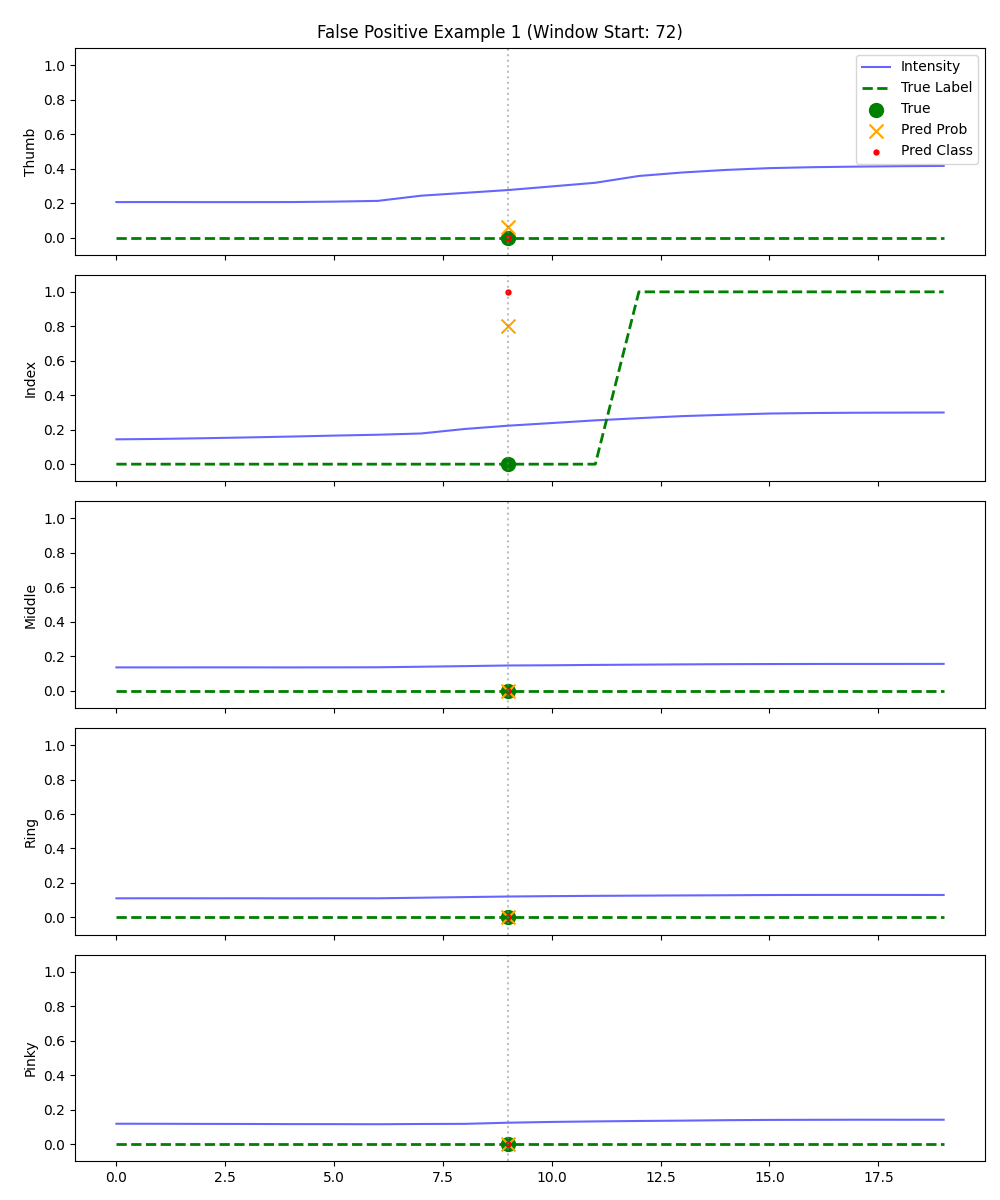

In [19]:
# Visualize False Window (Residual CNN)
from IPython.display import Image, display

# Path to a pre-generated false positive/negative plot
# You can change this to 'false_negative_0.png' or others found in the folder
image_path = CURRENT_DIR / "residual_CNN" / "test_results" / "false_positive_0.png"

if image_path.exists():
    print(f"Displaying: {image_path.name}")
    display(Image(filename=image_path))
else:
    print(f"Image not found at {image_path}")
    print("Please ensure you have run the test_residual_CNN.py script to generate these images.")

Model Comparison (Validation Set)
Metric          FCNN       CNN        ResCNN    
---------------------------------------------
Accuracy        0.9881     0.9598     0.9855
Precision       0.8854     0.5423     0.8753
Recall          0.8669     0.9561     0.8170
F1 Score        0.8761     0.6921     0.8452


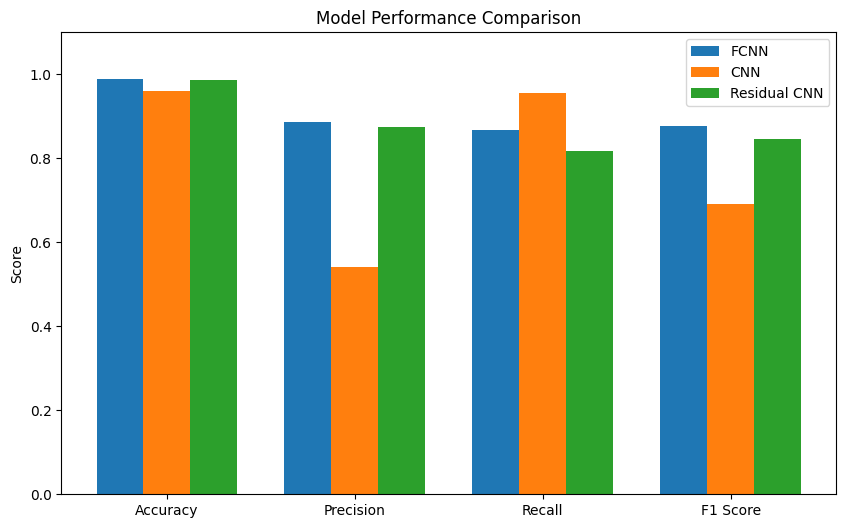

In [20]:
# Comparison
print("Model Comparison (Validation Set)")
print(f"{'Metric':<15} {'FCNN':<10} {'CNN':<10} {'ResCNN':<10}")
print("-" * 45)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    v_fcnn = metrics_fcnn.get(metric, 0)
    v_cnn = metrics_cnn.get(metric, 0)
    v_res = metrics_res.get(metric, 0)
    print(f"{metric:<15} {v_fcnn:.4f}     {v_cnn:.4f}     {v_res:.4f}")

# Bar Chart
labels = list(metrics_fcnn.keys())
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, metrics_fcnn.values(), width, label='FCNN')
rects2 = ax.bar(x, metrics_cnn.values(), width, label='CNN')
rects3 = ax.bar(x + width, metrics_res.values(), width, label='Residual CNN')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)

plt.show()